## Learning Machine Learning Step by Step
#### by Jord HANUS
#### First project: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

Sentiment analysis constitutes a major branch of machine learning (ML), specifically of natural language processing (NLP), for its many use cases in industry as well as high academic relevance.  Classic examples include the processing of customer feedback to assess priority (of questions or complaints) or brand popularity (via online reviews). In the subfield of economics and finance, market sentiments are of great interest. In this project I look in particular at the ‘polarity’ of financial news items and company press releases, an interesting case study that could allow to complement typical periodic surveys designed to capture (investor) market sentiment. Steering clear from advanced NLP techniques, in this project I adopt a modest approach, and utilize only basic ML techniques. In particular, I will analyze the financial news data solely through a classic bag-of-words approach, implemented through a range of basic ML models and a simple deep learning (DL) model. An important contribution I hope to make, however, is to draw attention to looking beyond the typical model accuracy metric to properly understand the pros and cons of a model in case of imbalanced data.

In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
import random

In [4]:
#Reading the data
df = pd.read_csv('Project1_data.csv')

#Take a closer look at some random samples to get a feel of the full text ('Sentence')
for i in range(10):
    j=random.randint(0,len(df))
    print(df.iloc[j,0],"(",df.iloc[j,1],")")

Finnish consumer packaging manufacturer Huhtamaki Oyj said it swung to a net profit of 84.1 mln euro $ 105.6 mln in the first nine months of 2006 from a net loss of 2.6 mln euro $ 3.3 mln in the same period of 2005 . ( positive )
`` Marimekko operates in an industry in which changes in the business climate are reflected in consumer demand . ( neutral )
According to the announcement of the Helsinki Stock Exchange the share of Sentera shall be delisted from the NM-list of the Helsinki Stock Exchange accordingly . ( neutral )
Dolce & Gabbana has asked the European Union to declare Marimekko Corporation 's `` Unikko '' floral pattern trademark invalid , in a continuing dispute between the two companies . ( neutral )
Olvi expects sales and market share to increase in the first quarter of 2010 . ( positive )
Full-year net sales are expected to increase by approximately 10 % , the company said . ( positive )
ADPnews - Aug 3 , 2009 - Finnish media group Ilkka-Yhtyma Oyj HEL : ILK2S said today 

This dataset is very *simple* in that it only contains one dependent and one independent variable. Obviously, the kicker is in *activating* the independent variable ('Sentence') in such ways that it can in fact predict with reasonable confidence the three-pronged dependent variable ('Sentiment', with values 'positive', 'negative' and 'neutral').
This will be a limited analysis not taking into account the (possible) meaning of the words or tokens in the source. An obvious area of improvement would this be to utilize stemming and annotation tools to help the learning machine to better *understand* the text it is analysing. That said, my bag-of-words approach does quite well, all things considered!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None
Number of duplicate records: 6


[Text(0.5, 1.0, "Number of records by 'Sentiment'")]

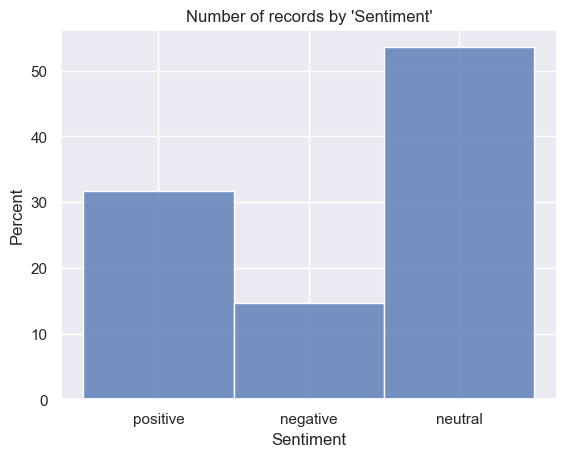

In [16]:
#Some preprocessing checks
print(df.info())
print(f"Number of duplicate records:",df.duplicated().sum())

sns.histplot(x = df.Sentiment,stat='percent').set(title="Number of records by 'Sentiment'")

We immediately see that the dataset is quite unbalanced as only a small fraction of all records lead to a 'negative' sentiment. Also the 'positive' sentiment is quite underrepresented compared to the large number of 'neutral' sentiments. Even though this most likely reflects reality, for the purposes of our Machine Learning model, we will need to resample the dataset to create better balance. I choose to upsample the 'positive' and 'negative' records to not loose information which would have followed from downsampling the 'neutral' cases. Resampling is important because otherwise the model (and the general model metrics such as accuracy) will heavily favour the neutral cases and have a low recall on the underrepresented sentiments (https://towardsdatascience.com/smote-fdce2f605729). Put differently, our oversampling technique will increase recall but decrease precision. See below for a more extensive discussion of this tradeoff in this case.
Below I will compare results for no resampling with resampling using the SMOTE package (see below).
First I run some simple graphs to better understand the data.

Question 1) Is there a correlation between the length of the message and the sentiment? Not really

[Text(0.5, 1.0, 'Density distribution of character length of "Sentence" by "Sentiment"')]

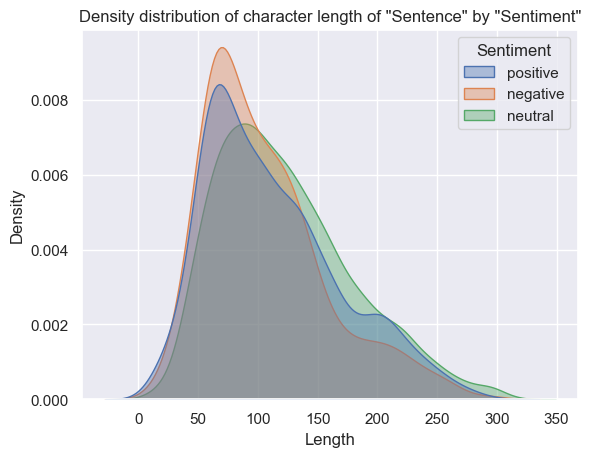

In [19]:
df['Length'] = df.loc[:,'Sentence'].str.len()
sns.kdeplot(data=df, 
            x="Length", 
            hue="Sentiment", 
            fill=True, 
            common_norm=False, 
            alpha=0.4).set(title='Density distribution of character length of "Sentence" by "Sentiment"')

Question 2) Is the occurence of numbers in the text significant? Yes, one could conclude that messages without numbers have a much smaller chance to be negative. I experimented with adding an extra column "Numbers" with value True/False (1/0) to indicate if numbers were mentioned in the text (since I will remove all numeric characters during preprocessing), but since this did not impact the results in any meaningful way, in the end I removed this step (less is more!).

[Text(0.5, 1.0, "Does the 'Sentence' contain numbers?")]

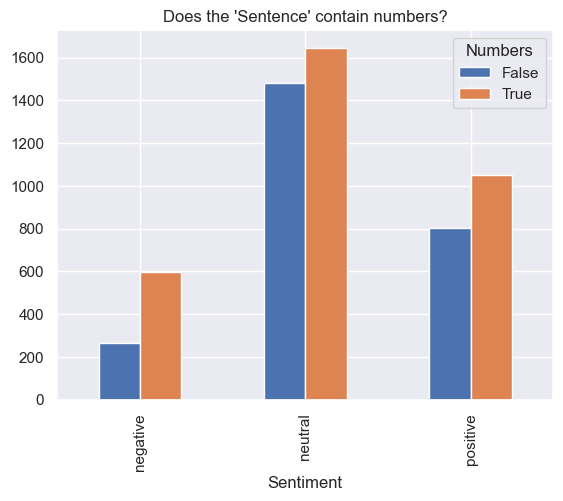

In [21]:
df['Numbers'] = df.Sentence.str.extract('(\d+)')
df['Numbers'] = pd.to_numeric(df['Numbers']).notnull()

pd.crosstab(df.Sentiment,df.Numbers).plot.bar().set(title="Does the 'Sentence' contain numbers?")

Question 3) What about if a firm is mentioned by name? This unfortunately falls beyond the scope of our simple exercise as it requires more Named Entity Recognition and similar more advanced NLP techniques.

I now proceed to the actual analysis: in the appendices below the gridsearches for the different classifiers are documented. In the snippets and graphs below I only show the fine-tuned models. 

In [38]:
#The sklearn libraries we need
#!pip install xgboost
#!pip install imblearn
#!pip install eli5
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, recall_score,precision_score,f1_score
from sklearn import set_config
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

set_config(display='diagram')

In [39]:
#Prepping the data from scratch
df = pd.read_csv('data.csv')

X = df.Sentence
y = df.Sentiment
y = y.replace({'positive':2, 'negative':0,'neutral':1}) #this is needed for XGBoost, and doesn't hinder performance for the other models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=1,stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4673,) (1169,) (4673,) (1169,)


In [40]:
#All the steps of the pipeline:

#Two possible vectorizers for 'Sentence' and the scaler
vect1 = TfidfVectorizer(use_idf=False,             #or in other words: CountVectorizer
                       analyzer= "word",
                       ngram_range=(1,2),
                       token_pattern= '[a-z]{2,}',
                       strip_accents='unicode',
                       max_features=None)

vect2 = TfidfVectorizer(analyzer= "word",
                       ngram_range=(1,1),
                       token_pattern= '[a-z]{2,}',
                       strip_accents='unicode',
                       max_features=None)

scaler = MaxAbsScaler()

#The oversampling technique of SMOTE, which is superior to manual (copy/paste) oversampling
#In the pipeline this step comes after the feature engineering
over=SMOTE(random_state=1)

#The various classifiers used with their gridsearch-optimized hyperparameters
clf1 = SGDClassifier(random_state=1,
                    loss='log',
                    penalty='l1')
clf2 = LogisticRegression(random_state=1,
                         C=1.5,
                         solver='newton-cg')
clf31 = RandomForestClassifier(random_state=1,
                             criterion='gini',
                             max_depth=20,
                             n_estimators=10)
clf32 = RandomForestClassifier(random_state=1,
                             criterion='entropy',
                             max_depth=5,
                             n_estimators=50)
clf41 = LinearSVC(random_state=1,
                dual=False,
                loss='squared_hinge',
                penalty='l1')
clf42 = LinearSVC(random_state=1,
                dual=True,
                loss='hinge',
                penalty='l2')
clf5 = XGBClassifier(random_state=1,
                    learning_rate=0.3,
                    gamma=0,
                    max_depth=15,
                    min_child_weight=1,
                    colsample_bytree=0.7
                    )
clf6 = MultinomialNB()

#Here only cross-validation, the hyperparameter tuning was done below (see appendices)
params = []

#All the pipelines, to be implemented in the following snippet
pipe_SGD = make_pipeline(vect2,scaler,clf1)
pipe_SGD_SMOTE = make_pipeline(vect2,scaler,over,clf1)

pipe_LR = make_pipeline(vect2,scaler,clf2)
pipe_LR_SMOTE = make_pipeline(vect2,scaler,over,clf2)

pipe_RF = make_pipeline(vect2,scaler,clf31)
pipe_RF_SMOTE = make_pipeline(vect2,scaler,over,clf32)

pipe_SVC = make_pipeline(vect2,scaler,clf41)
pipe_SVC_SMOTE = make_pipeline(vect1,scaler,over,clf42)

pipe_XGB = make_pipeline(vect1,scaler,clf5)
pipe_XGB_SMOTE = make_pipeline(vect1,scaler,over,clf5)

pipe_NB = make_pipeline(vect1,scaler,clf6)
pipe_NB_SMOTE = make_pipeline(vect1,scaler,over,clf6)

pipelines = [pipe_SGD,pipe_SGD_SMOTE,
             pipe_LR,pipe_LR_SMOTE,
             pipe_RF,pipe_RF_SMOTE,
             pipe_SVC,pipe_SVC_SMOTE,
             pipe_XGB,pipe_XGB_SMOTE,
             pipe_NB,pipe_NB_SMOTE
            ]

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('sgdclassifier',
                 SGDClassifier(loss='log', penalty='l1', random_state=1))])
              precision    recall  f1-score   support

           0       0.36      0.34      0.35       172
           1       0.74      0.77      0.75       626
           2       0.78      0.76      0.77       371

    accuracy                           0.70      1169
   macro avg       0.63      0.62      0.62      1169
weighted avg       0.70      0.70      0.70      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


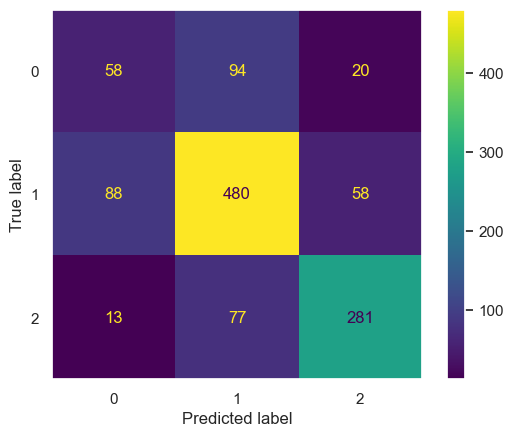

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('smote', SMOTE(random_state=1)),
                ('sgdclassifier',
                 SGDClassifier(loss='log', penalty='l1', random_state=1))])
              precision    recall  f1-score   support

           0       0.43      0.54      0.48       172
           1       0.76      0.74      0.75       626
           2       0.77      0.70      0.73       371

    accuracy                           0.70      1169
   macro avg       0.65      0.66      0.65      1169
weighted avg       0.71      0.70      0.70      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


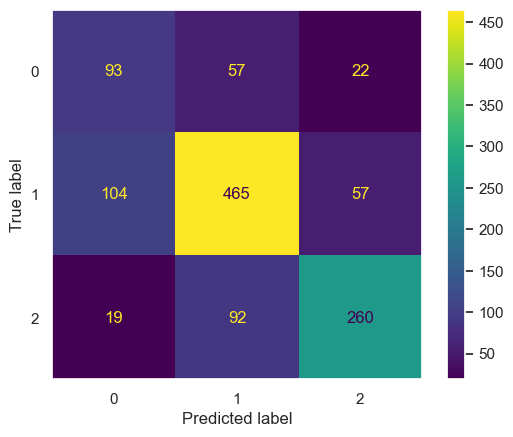

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('logisticregression',
                 LogisticRegression(C=1.5, random_state=1,
                                    solver='newton-cg'))])
              precision    recall  f1-score   support

           0       0.33      0.30      0.31       172
           1       0.72      0.78      0.75       626
           2       0.79      0.71      0.74       371

    accuracy                           0.69      1169
   macro avg       0.61      0.60      0.60      1169
weighted avg       0.68      0.69      0.68      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


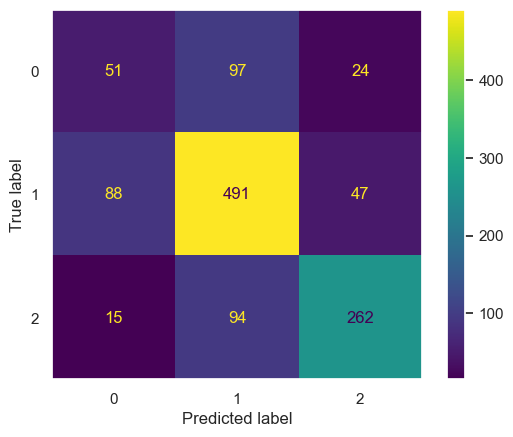

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('smote', SMOTE(random_state=1)),
                ('logisticregression',
                 LogisticRegression(C=1.5, random_state=1,
                                    solver='newton-cg'))])
              precision    recall  f1-score   support

           0       0.37      0.44      0.40       172
           1       0.74      0.75      0.74       626
           2       0.79      0.71      0.75       371

    accuracy                           0.69      1169
   macro avg       0.63      0.63      0.63      1169
weighted avg       0.70      0.69      0.69      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


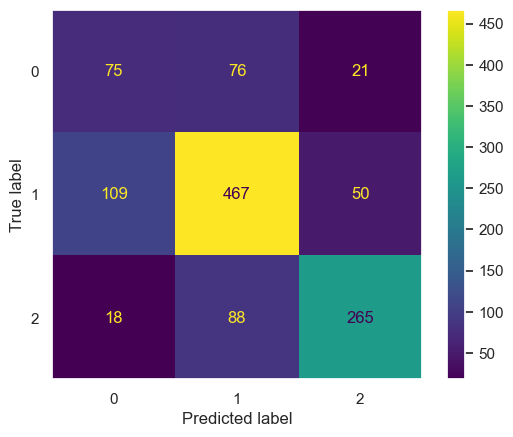

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_estimators=10,
                                        random_state=1))])
              precision    recall  f1-score   support

           0       0.43      0.03      0.06       172
           1       0.58      0.96      0.73       626
           2       0.73      0.25      0.37       371

    accuracy                           0.60      1169
   macro avg       0.58      0.41      0.39      1169
weighted avg       0.61      0.60      0.52      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


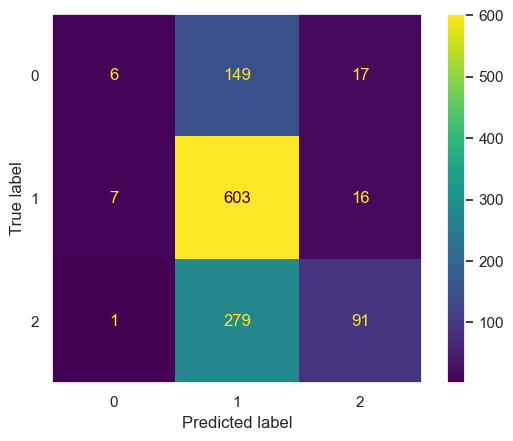

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('smote', SMOTE(random_state=1)),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=50, random_state=1))])
              precision    recall  f1-score   support

           0       0.33      0.38      0.35       172
           1       0.65      0.86      0.74       626
           2       0.65      0.24      0.35       371

    accuracy                           0.59      1169
   macro avg       0.54      0.49      0.48      1169
weighted avg       0.60      0.59      0.56      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


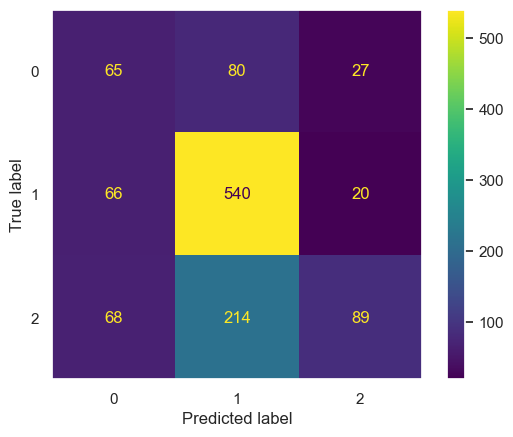

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(strip_accents='unicode',
                                 token_pattern='[a-z]{2,}')),
                ('maxabsscaler', MaxAbsScaler()),
                ('linearsvc',
                 LinearSVC(dual=False, penalty='l1', random_state=1))])
              precision    recall  f1-score   support

           0       0.35      0.33      0.34       172
           1       0.73      0.77      0.75       626
           2       0.79      0.73      0.76       371

    accuracy                           0.69      1169
   macro avg       0.62      0.61      0.61      1169
weighted avg       0.69      0.69      0.69      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


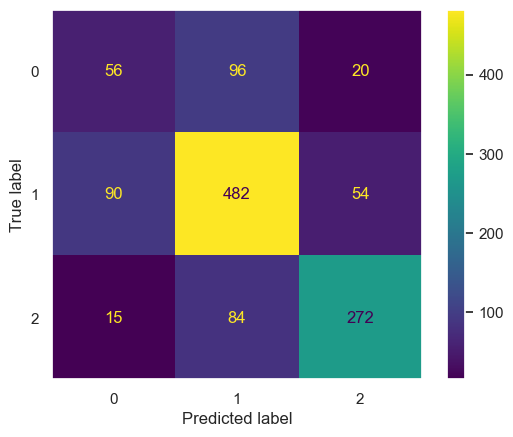

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 token_pattern='[a-z]{2,}', use_idf=False)),
                ('maxabsscaler', MaxAbsScaler()),
                ('smote', SMOTE(random_state=1)),
                ('linearsvc', LinearSVC(loss='hinge', random_state=1))])
              precision    recall  f1-score   support

           0       0.33      0.37      0.35       172
           1       0.74      0.76      0.75       626
           2       0.80      0.71      0.75       371

    accuracy                           0.69      1169
   macro avg       0.62      0.61      0.62      1169
weighted avg       0.70      0.69      0.69      1169



C:\Users\jhanus\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


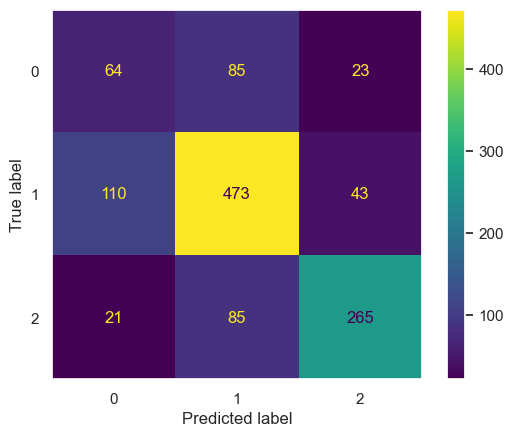

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 token_pattern='[a-z]{2,}', use_idf=False)),
                ('maxabsscaler', MaxAbsScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, early_stopping_rounds=None,
                               enable_categori...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=1, missing=nan,
                

C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


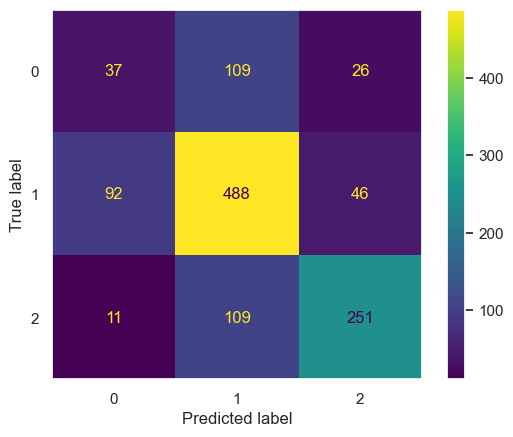

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 token_pattern='[a-z]{2,}', use_idf=False)),
                ('maxabsscaler', MaxAbsScaler()),
                ('smote', SMOTE(random_state=1)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, early_stop...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=1, missing=nan,
                              

C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


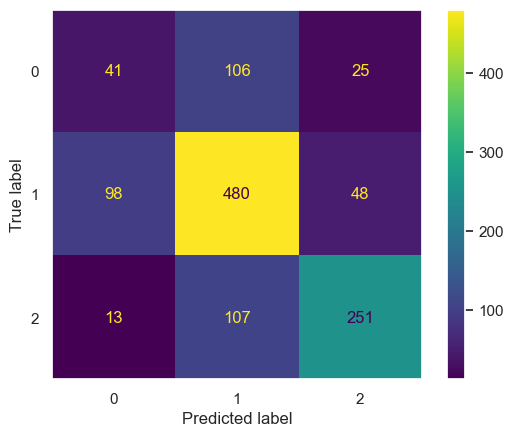

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 token_pattern='[a-z]{2,}', use_idf=False)),
                ('maxabsscaler', MaxAbsScaler()),
                ('multinomialnb', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.32      0.24      0.28       172
           1       0.71      0.81      0.76       626
           2       0.76      0.65      0.70       371

    accuracy                           0.68      1169
   macro avg       0.59      0.57      0.58      1169
weighted avg       0.67      0.68      0.67      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


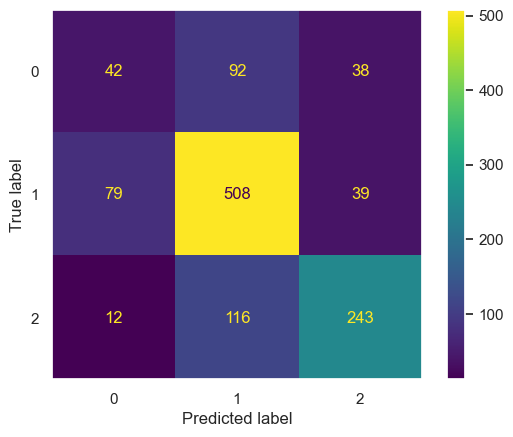

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 token_pattern='[a-z]{2,}', use_idf=False)),
                ('maxabsscaler', MaxAbsScaler()),
                ('smote', SMOTE(random_state=1)),
                ('multinomialnb', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.36      0.57      0.44       172
           1       0.78      0.75      0.76       626
           2       0.79      0.61      0.69       371

    accuracy                           0.68      1169
   macro avg       0.64      0.64      0.63      1169
weighted avg       0.72      0.68      0.69      1169



C:\Users\jhanus\AppData\Local\Temp\ipykernel_47752\4256782200.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


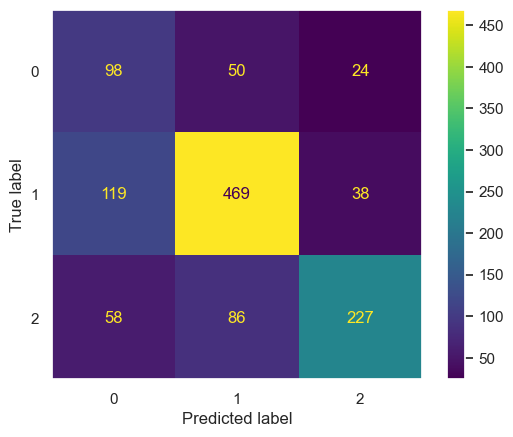

In [58]:
recall_negative=[]
precision_negative=[]
model_accuracy=[]
model_f1=[]
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    y_test_pred = pipe.predict(X_test)
    print(pipe)
    print(classification_report(y_test, y_test_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.grid(b=None)
    plt.show()
    recall_negative.append(recall_score(y_test,y_test_pred, labels=[0],average=None))
    precision_negative.append(precision_score(y_test,y_test_pred, labels=[0],average=None))
    model_accuracy.append(accuracy_score(y_test,y_test_pred))
    model_f1.append(f1_score(y_test,y_test_pred,average='weighted'))

In [59]:
pipe_names = ['SGD','SGD_SMOTE',
             'LR','LR_SMOTE',
             'RF','RF_SMOTE',
             'SVC','SVC_SMOTE',
             'XGB','XGB_SMOTE',
             'NB','NB_SMOTE']

precision_negative = list(np.array(precision_negative).flat)
recall_negative = list(np.array(recall_negative).flat)
model_accuracy = list(np.array(model_accuracy).flat)
model_f1 = list(np.array(model_f1).flat)

In [60]:
#Summary for ML models

summary = pd.concat([pd.DataFrame(data=recall_negative,
                        index=pipe_names,
                        columns=['Recall negative']),
          pd.DataFrame(data=precision_negative,
                        index=pipe_names,
                        columns=['Precision negative']),
          pd.DataFrame(data=model_accuracy,
                       index=pipe_names,
                      columns=['Model accuracy']),
          pd.DataFrame(data=model_f1,
                       index=pipe_names,
                      columns=['Model weighted f1'])],
          axis=1)

summary.round(decimals=2)

,Recall negative,Precision negative,Model accuracy,Model weighted f1
SGD,0.34,0.36,0.70,0.70
SGD_SMOTE,0.54,0.43,0.70,0.70
LR,0.30,0.33,0.69,0.68
LR_SMOTE,0.44,0.37,0.69,0.69
RF,0.03,0.43,0.60,0.52
RF_SMOTE,0.38,0.33,0.59,0.56
SVC,0.33,0.35,0.69,0.69
SVC_SMOTE,0.37,0.33,0.69,0.69
XGB,0.22,0.26,0.66,0.66
XGB_SMOTE,0.24,0.27,0.66,0.66


[Text(0.5, 1.0, 'Model metrics')]

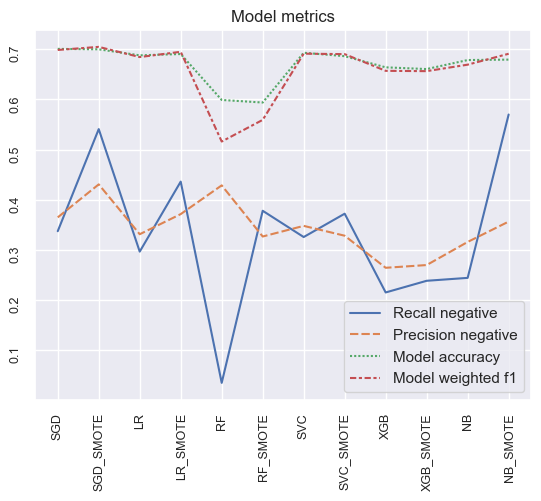

In [61]:
fig = sns.lineplot(data=summary)
fig.tick_params(labelsize=9, rotation=90)
fig.set(title="Model metrics")

The above figure (and table) handily summarizes the main results of our ML models. The Random Forest Classifier performed the worst, probably a result of overfitting, while the XGB classifier did worse than I had thought, given its successful application to a wide range of challenges. Overall a 70% accuracy is acceptable but not overly high, given that a baseline majority class predictor would score 54%. <br>
Of more interest, and often overlooked (at least on the Kaggle community), are the recall and precision scores for the imbalanced class(es), in this case the ‘negative’ sentiment.  Consider the most extreme case of the non-resampled RF classifier: even though it scored an acceptable 43% precision on the ‘negative’ cases, it’s recall was only 3% and 25% for ‘positive’ vs. 96% for ‘neutral’ cases. In other words, in the vast majority of cases, this classifier basically simply predicted the majority class. The contrast with maybe our best predictors, the 'SMOTED' SGD and MNB, is clear, as they manage to correctly label 57% of all ‘negative’ cases. Evidently, this high recall comes at the expense of lower performance on the other sentiments. <br>
In the end, the choice of model will depend on the use case or business needs: if it is considered more important to avoid false negative results on the ‘negative’ sentiment (i.e. minimize the occurrence of bad news mislabeled as neutral or positive news), our MNB_SMOTE model is likely the best choice. If overall accuracy is key, SGD_SMOTE is the slight winner of the regular ML models.<br>
I will now turn to 2 relatively simple Deep Learning models to see if they give us a better performance (TBC).

In [62]:
#Supplementary materials: gridsearch per model

# SGDClassifier
# vect = TfidfVectorizer(analyzer= "word",
#                        ngram_range=(1,1),
#                        token_pattern= '[a-z]{2,}',
#                        strip_accents='unicode',
#                        min_df=20)

# scaler = MaxAbsScaler() 

# over = SMOTE(random_state=1)

# clf1 = SGDClassifier(random_state=1)

# pipe1 = make_pipeline(vect, scaler, clf1)
# pipe2 = make_pipeline(vect, scaler, over, clf1)

# params = [{
#     'tfidfvectorizer__use_idf': [True,False],
#     'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
#     'tfidfvectorizer__max_features': [500,None],
#     'tfidfvectorizer__min_df': [1,3,5,10],
#     #'tfidfvectorizer__stop_words': ['english',None],
#     #'tfidfvectorizer__lowercase': [True,False],
#     #'sgdclassifier__penalty': ['l2', 'l1'],
#     #'sgdclassifier__loss': ['hinge', 'log', 'perceptron'],
#     'sgdclassifier__penalty': ['l1'],
#     'sgdclassifier__loss': ['log'],

#     }]

# gs1 = GridSearchCV(pipe1, params, cv=20, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs1.fit(X_train, y_train)
# y_test_pred = gs1.predict(X_test)
# print("Grid search for SGD, no SMOTE")
# print(gs1.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

# gs2 = GridSearchCV(pipe2, params, cv=20, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs2.fit(X_train, y_train)
# y_test_pred = gs2.predict(X_test)
# print("Grid search for SGD, with SMOTE")
# print(gs2.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

In [63]:
#Logistic regression
# clf2 = LogisticRegression(random_state=1)

# pipe1 = make_pipeline(vect, scaler, clf2)
# pipe2 = make_pipeline(vect, scaler, over, clf2)

# params = [{
#     'tfidfvectorizer__use_idf': [True,False],
#     'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
#     'tfidfvectorizer__max_features': [500,None],
#     'tfidfvectorizer__min_df': [1,3,5,10],
#     'logisticregression__C': [0.8, 1.0, 1.5, 2],
#     'logisticregression__solver': ['liblinear', 'newton-cg'],

#     }]

# gs1 = GridSearchCV(pipe1, params, cv=20, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs1.fit(X_train, y_train)
# y_test_pred = gs1.predict(X_test)
# print("Grid search for LR, no SMOTE")
# print(gs1.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

# gs2 = GridSearchCV(pipe2, params, cv=20, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs2.fit(X_train, y_train)
# y_test_pred = gs2.predict(X_test)
# print("Grid search for LR, with SMOTE")
# print(gs2.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

In [64]:
#Random forest
# clf3 = RandomForestClassifier(random_state=1)

# pipe1 = make_pipeline(vect, scaler, clf3)
# pipe2 = make_pipeline(vect, scaler, over, clf3)

# params = [{
#     'tfidfvectorizer__use_idf': [True,False],
#     'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
#     'tfidfvectorizer__max_features': [500,None],
#     'randomforestclassifier__n_estimators': [10, 20, 50],
#     'randomforestclassifier__criterion': ['gini','entropy'],
#     'randomforestclassifier__max_depth': [5,10,20],
#    }]

# gs1 = GridSearchCV(pipe1, params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs1.fit(X_train, y_train)
# y_test_pred = gs1.predict(X_test)
# print("Grid search for RF, no SMOTE")
# print(gs1.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

# gs2 = GridSearchCV(pipe2, params, cv=20, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs2.fit(X_train, y_train)
# y_test_pred = gs2.predict(X_test)
# print("Grid search for RF, with SMOTE")
# print(gs2.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

In [65]:
#Linear SVC
# clf4 = LinearSVC(random_state=1)

# pipe1 = make_pipeline(vect, scaler, clf4)
# pipe2 = make_pipeline(vect, scaler, over, clf4)

# params = [{
#     'tfidfvectorizer__use_idf': [True,False],
#     'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
#     'tfidfvectorizer__max_features': [500,None],
#      'linearsvc__penalty': ['l2', 'l1'],
#      'linearsvc__loss': ['hinge', 'squared_hinge'],
#      'linearsvc__dual': [True,False]
# }]

# gs1 = GridSearchCV(pipe1, params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs1.fit(X_train, y_train)
# y_test_pred = gs1.predict(X_test)
# print("Grid search for SVC, no SMOTE")
# print(gs1.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

# gs2 = GridSearchCV(pipe2, params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs2.fit(X_train, y_train)
# y_test_pred = gs2.predict(X_test)
# print("Grid search for SVC, with SMOTE")
# print(gs2.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

In [66]:
#XGB
# clf5 = XGBClassifier(random_state=42,
#                     learning_rate=0.3,
#                     gamma=0,
#                     max_depth=15,
#                     min_child_weight=1,
#                     colsample_bytree=0.7
#                     )

# pipe1 = make_pipeline(vect, scaler, clf5)
# pipe2 = make_pipeline(vect, scaler, over, clf5)

# params = [{
#      'tfidfvectorizer__use_idf': [True,False],
#      'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
#      'tfidfvectorizer__max_features': [500,None],
#      'xgbclassifier__learning_rate': [0.3],
#      'xgbclassifier__max_depth': [15, 25],
#      'xgbclassifier__min_child_weight': [1, 5],
#      'xgbclassifier__gamma': [0.0, 0.15],
#      'xgbclassifier__colsample_bytree': [0.5, 0.7, 0.9]
#     }]

# gs1 = GridSearchCV(pipe1, params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs1.fit(X_train, y_train)
# y_test_pred = gs1.predict(X_test)
# print("Grid search for XGB, no SMOTE")
# print(gs1.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))

# gs2 = GridSearchCV(pipe2, params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
# gs2.fit(X_train, y_train)
# y_test_pred = gs2.predict(X_test)
# print("Grid search for XGB, with SMOTE")
# print(gs2.best_params_)
# print(classification_report(y_test, y_test_pred))
# print(ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred))